Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1m']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.75):
        relative_volume_level = self.indicators.calculate_relative_volume_level(dataset)
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']
        self.base_asset_precision = pair_info['baseAssetPrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.base_asset_balance = "{:0.0{}f}".format(float(self.base_asset_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.quote_asset_balance = "{:0.0{}f}".format(float(self.quote_asset_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_last_price = "{:0.0{}f}".format(float(self.pair_last_price), self.precision).rstrip('0').rstrip('.')

        self.pair_buy_balance = float(self.quote_asset_balance) / float(self.pair_last_price)
        self.pair_buy_balance = "{:0.0{}f}".format(float(self.pair_buy_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_sell_balance = float(self.base_asset_balance) * float(self.pair_last_price)
        self.pair_sell_balance = "{:0.0{}f}".format(float(self.pair_sell_balance), self.precision).rstrip('0').rstrip('.')

        self.pair_combined_base_balance = float(self.pair_buy_balance) + float(self.base_asset_balance)
        self.pair_combined_base_balance = "{:0.0{}f}".format(float(self.pair_combined_base_balance), self.base_asset_precision).rstrip('0').rstrip('.')

        self.pair_combined_quote_balance = float(self.pair_sell_balance) + float(self.quote_asset_balance)
        self.pair_combined_quote_balance = "{:0.0{}f}".format(float(self.pair_combined_quote_balance), self.precision).rstrip('0').rstrip('.')

    def print_balance(self):
        print("\n")
        print('pair: ', self.pair)
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=100)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=100):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if float(self.info.pair_buy_balance) > float(self.info.base_asset_balance):
            self.position = 'sell'
        elif float(self.info.base_asset_balance) > float(self.info.pair_buy_balance):
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = float(self.info.pair_buy_balance)
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = float(self.info.base_asset_balance)
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        quantity = "{:0.0{}f}".format(float(quantity), self.info.precision).rstrip('0').rstrip('.')

        print('traded quantity:', quantity)
        self.pair.info.calculate_balance()
        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals = intervals + ['price']

        self.info = self.get_pair_info(client, pair)

        super().__init__(self)

        self.interval = self.get_datasets(client, intervals)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

        for pair in list(self.pairs.keys()):
            for interval in intervals:
                if initial_plot:
                    print("\n")
                    print('pair: ', pair)
                    print('interval: ', interval)

                self.pairs[pair].interval[interval].indicators.update(
                    self.pairs[pair].interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



pair:  BTCUSDT
interval:  1m


ATR
time
2020-06-20 05:37:00    3.584993
2020-06-20 05:38:00    3.584993
2020-06-20 05:39:00    3.584993
2020-06-20 05:40:00    3.584993
2020-06-20 05:41:00    3.584993
                         ...   
2020-06-20 11:12:00    6.848517
2020-06-20 11:13:00    7.181480
2020-06-20 11:14:00    7.552089
2020-06-20 11:15:00    7.650511
2020-06-20 11:16:00    7.429046
Length: 340, dtype: float64


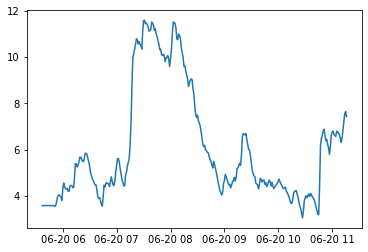





KDJ
                             K          D          J
time                                                
2020-06-20 05:37:00  35.978836  45.326279  17.283951
2020-06-20 05:38:00  32.778322  41.143627  16.047714
2020-06-20 05:39:00  37.003730  39.763661  31.483868
2020-06-20 05:40:00  48.389112  42.638811  59.889712
2020-06-20 05:41:00  49.971006  45.082876  59.747267
...                        ...        ...        ...
2020-06-20 11:12:00  28.470581  35.272377  14.866988
2020-06-20 11:13:00  21.111715  30.552156   2.230831
2020-06-20 11:14:00  24.213953  28.439422  15.763015
2020-06-20 11:15:00  32.268634  29.715826  37.374251
2020-06-20 11:16:00  38.236874  32.556175  49.598271

[340 rows x 3 columns]


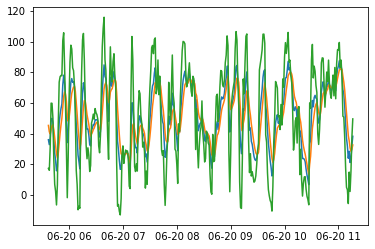





MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-20 05:37:00 -0.059904    -0.059904   0.000000
2020-06-20 05:38:00 -0.059904    -0.059904   0.000000
2020-06-20 05:39:00 -0.047490    -0.054816   0.007326
2020-06-20 05:40:00  0.018531    -0.029970   0.048501
2020-06-20 05:41:00  0.008255    -0.018599   0.026854
...                       ...          ...        ...
2020-06-20 11:12:00  4.144539     5.916685  -1.772146
2020-06-20 11:13:00  2.856566     5.304662  -2.448096
2020-06-20 11:14:00  2.222552     4.688240  -2.465688
2020-06-20 11:15:00  2.005219     4.151635  -2.146417
2020-06-20 11:16:00  1.799328     3.681174  -1.881846

[340 rows x 3 columns]


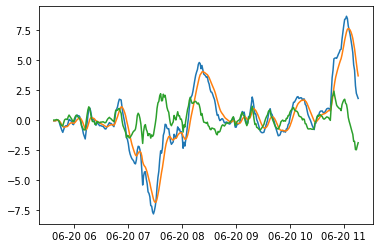





RSI
time
2020-06-20 05:37:00     0.000000
2020-06-20 05:38:00     0.000000
2020-06-20 05:39:00    28.674186
2020-06-20 05:40:00    54.953633
2020-06-20 05:41:00    42.335403
                         ...    
2020-06-20 11:12:00    47.987843
2020-06-20 11:13:00    30.976836
2020-06-20 11:14:00    41.892174
2020-06-20 11:15:00    48.863636
2020-06-20 11:16:00    48.582062
Name: close, Length: 340, dtype: float64


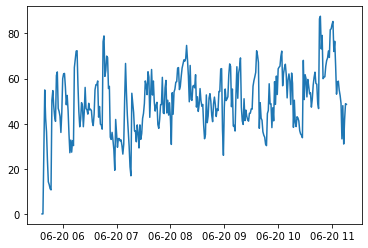





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-20 06:03:00  0.153238  0.167555  0.242993
2020-06-20 06:04:00  0.161250  0.144968  0.220332
2020-06-20 06:05:00  0.173948  0.124677  0.206398
2020-06-20 06:06:00  0.206223  0.111138  0.256113
2020-06-20 06:07:00  0.260038  0.095976  0.360101
...                       ...       ...       ...
2020-06-20 11:11:00  0.461998  0.092226  0.234447
2020-06-20 11:12:00  0.479882  0.075807  0.299593
2020-06-20 11:13:00  0.495381  0.062653  0.247609
2020-06-20 11:14:00  0.479978  0.091712  0.204064
2020-06-20 11:15:00  0.466628  0.078461  0.174580

[313 rows x 3 columns]


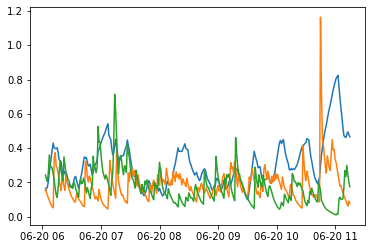





bollinger_bands
                           BB_up      BB_down   BB_width
time                                                    
2020-06-20 05:56:00  9290.650500  9290.650500   0.000000
2020-06-20 05:57:00  9290.404383  9290.262617   0.141767
2020-06-20 05:58:00  9290.194083  9289.894917   0.299167
2020-06-20 05:59:00  9290.030364  9289.562636   0.467728
2020-06-20 06:00:00  9289.979775  9289.369225   0.610550
...                          ...          ...        ...
2020-06-20 11:12:00  9316.417937  9300.852063  15.565873
2020-06-20 11:13:00  9316.010047  9301.091953  14.918094
2020-06-20 11:14:00  9315.685983  9301.589017  14.096966
2020-06-20 11:15:00  9315.446257  9302.310743  13.135514
2020-06-20 11:16:00  9315.028743  9302.991257  12.037486

[321 rows x 3 columns]


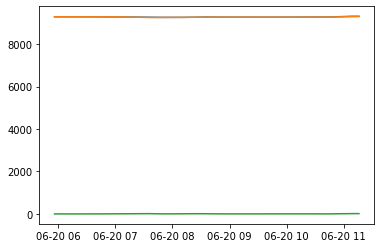





commodity_channel_index
time
2020-06-20 05:37:00         NaN
2020-06-20 05:38:00         NaN
2020-06-20 05:39:00         NaN
2020-06-20 05:40:00         NaN
2020-06-20 05:41:00         NaN
                         ...   
2020-06-20 11:12:00   -0.637853
2020-06-20 11:13:00   -1.641760
2020-06-20 11:14:00   -1.505342
2020-06-20 11:15:00   -0.940091
2020-06-20 11:16:00   -0.909620
Name: CCI, Length: 340, dtype: float64


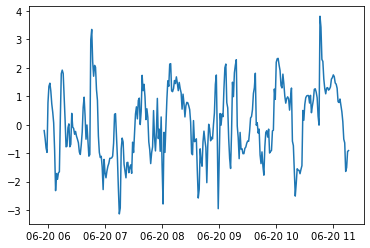





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-06-20 05:37:00  9295.730000  9296.990000  9295.100000  9295.250000   
2020-06-20 05:38:00  9295.437500  9296.975000  9292.025000  9293.247500   
2020-06-20 05:39:00  9293.521538  9295.476154  9291.045385  9293.429231   
2020-06-20 05:40:00  9293.054750  9295.269500  9291.743750  9294.590750   
2020-06-20 05:41:00  9294.450661  9295.182810  9293.133636  9294.195289   
...                          ...          ...          ...          ...   
2020-06-20 11:12:00  9303.474703  9309.011505  9301.058298  9306.276839   
2020-06-20 11:13:00  9305.864901  9307.710502  9296.812766  9299.458946   
2020-06-20 11:14:00  9299.321634  9304.863501  9296.304255  9300.592982   
2020-06-20 11:15:00  9300.547211  9305.427834  9299.541418  9303.517661   
2020-06-20 11:16:00  9303.502404  9305.142611  9302.147139  9304.3858

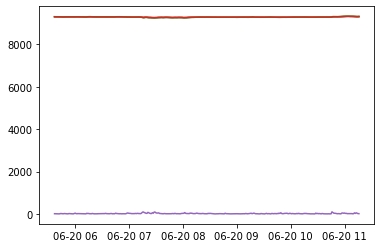





heikin_ashi
                            open         high          low      close
2020-06-20 05:37:00  9295.730000  9296.990000  9295.100000  9295.7675
2020-06-20 05:38:00  9295.748750  9296.970000  9291.000000  9293.9725
2020-06-20 05:39:00  9294.860625  9294.860625  9290.610000  9292.9000
2020-06-20 05:40:00  9293.880312  9295.170000  9292.080000  9293.8075
2020-06-20 05:41:00  9293.843906  9295.140000  9293.820000  9294.5250
...                          ...          ...          ...        ...
2020-06-20 11:12:00  9308.048401  9308.048401  9300.180000  9303.8650
2020-06-20 11:13:00  9305.956701  9307.060000  9294.690000  9301.2150
2020-06-20 11:14:00  9303.585850  9303.585850  9296.050000  9299.1750
2020-06-20 11:15:00  9301.380425  9305.710000  9301.160000  9303.2525
2020-06-20 11:16:00  9302.316463  9305.000000  9302.316463  9304.5625

[340 rows x 4 columns]


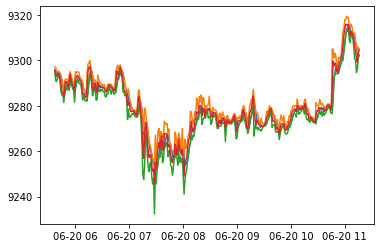





relative_volume_level
                       volume
time                         
2020-06-20 05:37:00       NaN
2020-06-20 05:38:00  0.000000
2020-06-20 05:39:00  0.000000
2020-06-20 05:40:00  0.000000
2020-06-20 05:41:00  0.000000
...                       ...
2020-06-20 11:12:00 -0.090326
2020-06-20 11:13:00  0.115492
2020-06-20 11:14:00 -0.064214
2020-06-20 11:15:00 -0.030500
2020-06-20 11:16:00 -0.046464

[340 rows x 1 columns]


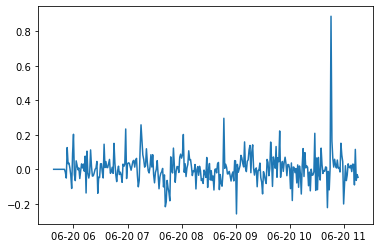





simple_moving_average
                         open      high       low     close     volume
time                                                                  
2020-06-20 05:37:00  9295.535  9296.980  9293.050  9293.915  12.978038
2020-06-20 05:38:00  9295.535  9296.980  9293.050  9293.915  12.978038
2020-06-20 05:39:00  9294.005  9295.890  9290.805  9293.045  10.384676
2020-06-20 05:40:00  9292.750  9294.990  9291.345  9294.330   8.095534
2020-06-20 05:41:00  9293.985  9295.155  9292.950  9294.575   6.197662
...                       ...       ...       ...       ...        ...
2020-06-20 11:12:00  9304.670  9309.780  9300.370  9304.610  42.277911
2020-06-20 11:13:00  9303.795  9307.310  9297.435  9301.620  40.903779
2020-06-20 11:14:00  9301.555  9305.250  9295.370  9298.605  46.220876
2020-06-20 11:15:00  9298.605  9304.575  9298.605  9303.070  16.421362
2020-06-20 11:16:00  9303.070  9305.355  9302.305  9304.900  11.952243

[340 rows x 5 columns]


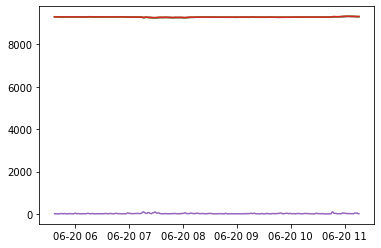





MACD_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    1.0
2020-06-20 05:40:00    1.0
2020-06-20 05:41:00    1.0
                      ... 
2020-06-20 11:12:00    0.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    0.0
2020-06-20 11:15:00    0.0
2020-06-20 11:16:00    0.0
Name: histogram, Length: 340, dtype: float64


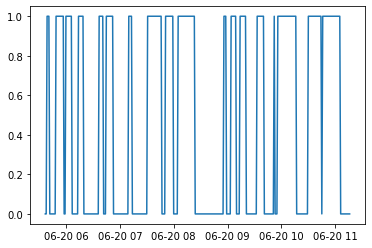





momentum_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    0.0
2020-06-20 05:40:00    1.0
2020-06-20 05:41:00    1.0
                      ... 
2020-06-20 11:12:00    0.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    0.0
2020-06-20 11:15:00    1.0
2020-06-20 11:16:00    1.0
Length: 340, dtype: float64


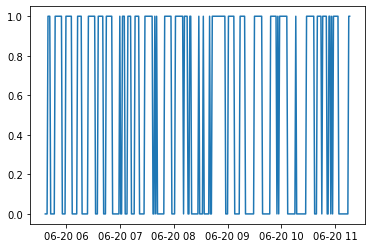





overtraded_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    1.0
2020-06-20 05:40:00    1.0
2020-06-20 05:41:00    1.0
                      ... 
2020-06-20 11:12:00    0.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
2020-06-20 11:16:00    1.0
Name: close, Length: 340, dtype: float64


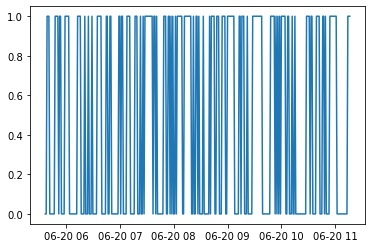





real_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    1.0
2020-06-20 05:40:00    1.0
2020-06-20 05:41:00    0.0
                      ... 
2020-06-20 11:12:00    1.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
2020-06-20 11:16:00    0.0
Length: 340, dtype: float64


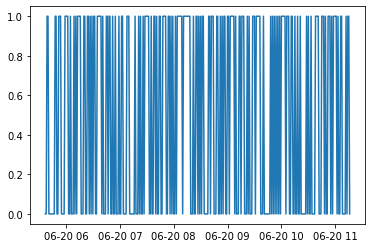





relative_volume_level_trigger
                     volume
time                       
2020-06-20 05:37:00     0.0
2020-06-20 05:38:00     0.0
2020-06-20 05:39:00     0.0
2020-06-20 05:40:00     0.0
2020-06-20 05:41:00     0.0
...                     ...
2020-06-20 11:12:00     0.0
2020-06-20 11:13:00     0.0
2020-06-20 11:14:00     0.0
2020-06-20 11:15:00     0.0
2020-06-20 11:16:00     0.0

[340 rows x 1 columns]


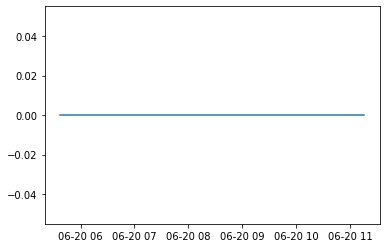





trend_strength_negative_trigger
time
2020-06-20 06:03:00    1.0
2020-06-20 06:04:00    1.0
2020-06-20 06:05:00    1.0
2020-06-20 06:06:00    1.0
2020-06-20 06:07:00    1.0
                      ... 
2020-06-20 11:11:00    1.0
2020-06-20 11:12:00    1.0
2020-06-20 11:13:00    1.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
Length: 313, dtype: float64


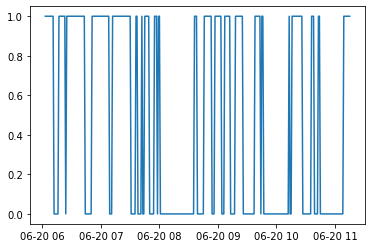





trend_strength_positive_trigger
time
2020-06-20 06:03:00    0.0
2020-06-20 06:04:00    0.0
2020-06-20 06:05:00    0.0
2020-06-20 06:06:00    0.0
2020-06-20 06:07:00    0.0
                      ... 
2020-06-20 11:11:00    0.0
2020-06-20 11:12:00    0.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    0.0
2020-06-20 11:15:00    0.0
Length: 313, dtype: float64


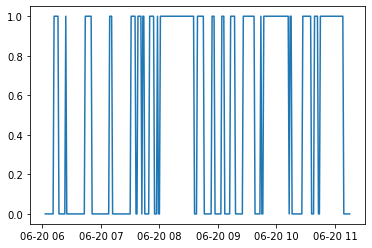





trend_strength_trigger
time
2020-06-20 06:03:00    0.0
2020-06-20 06:04:00    0.0
2020-06-20 06:05:00    0.0
2020-06-20 06:06:00    0.0
2020-06-20 06:07:00    1.0
                      ... 
2020-06-20 11:11:00    1.0
2020-06-20 11:12:00    1.0
2020-06-20 11:13:00    1.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
Name: ADX, Length: 313, dtype: float64


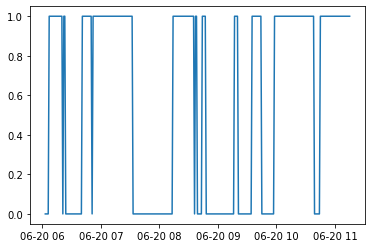





trend_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    1.0
2020-06-20 05:40:00    1.0
2020-06-20 05:41:00    0.0
                      ... 
2020-06-20 11:12:00    1.0
2020-06-20 11:13:00    0.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
2020-06-20 11:16:00    0.0
Length: 340, dtype: float64


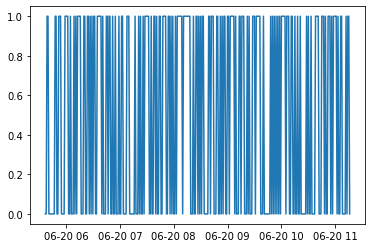





volatility_trigger
time
2020-06-20 05:37:00    0.0
2020-06-20 05:38:00    0.0
2020-06-20 05:39:00    0.0
2020-06-20 05:40:00    0.0
2020-06-20 05:41:00    0.0
                      ... 
2020-06-20 11:12:00    1.0
2020-06-20 11:13:00    1.0
2020-06-20 11:14:00    1.0
2020-06-20 11:15:00    1.0
2020-06-20 11:16:00    1.0
Length: 340, dtype: float64


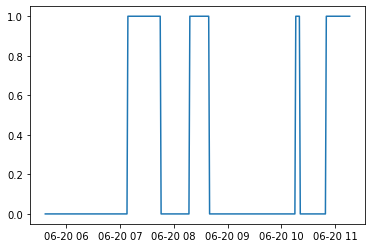

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [6]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

"\nscores = {}\nfor crypto_pair in symbols.values():\n    scores.update({crypto_pair.base_asset: 0})\n    scores.update({crypto_pair.quote_asset: 0})\n\nwhile True:\n    time.sleep(15)\n    for symbol in symbols.keys():\n        symbols[symbol].calculate_balance()\n        symbols[symbol].calculate_position()\n\n    scores = {}\n    for crypto_pair in symbols.values():\n        scores.update({crypto_pair.base_asset: 0})\n        scores.update({crypto_pair.quote_asset: 0})\n\n    for asset in scores.keys():\n        for symbol in symbols.keys():\n            if symbols[symbol].base_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and                         symbols[symbol].real_trigger_10m.iloc[-1]:\n                    scores.update({asset: scores[asset] + 1})\n                else:\n                    scores.update({asset: scores[asset] - 1})\n            elif symbols[symbol].quote_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and 

In [7]:
# --- Development separation --- #

In [8]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

'\ndef process_message(msg):\n    global symbols, traded_symbol\n    four_hours = 14400\n    milliseconds = 1000\n\n    msg = msg[\'data\'][\'k\']\n    symbol = msg[\'s\']\n    dataset = symbols[symbol].dataset\n    quote_asset_precision = symbols[symbol].quote_asset_precision\n    if symbol in symbols.keys():\n        last_data =             pd.DataFrame([["{:0.0{}f}".format(float(msg[\'o\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'h\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'l\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'c\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'v\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\')]], \n                         index=[datetime.datetime.fromtimestamp(int(ms

In [9]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()



pair:  BTCUSDT
base_asset_balance:  0.00807233
quote_asset_balance:  0
pair_last_price:  9300.44
pair_buy_balance:  0
pair_sell_balance:  75.07622083
pair_combined_base_balance:  0.00807233
pair_combined_quote_balance:  75.07622083




pair:  BTCUSDT
base_asset_balance:  0.00807233
quote_asset_balance:  0
pair_last_price:  9300.05
pair_buy_balance:  0
pair_sell_balance:  75.07307262
pair_combined_base_balance:  0.00807233
pair_combined_quote_balance:  75.07307262




pair:  BTCUSDT
base_asset_balance:  0.00807233
quote_asset_balance:  0
pair_last_price:  9299.58
pair_buy_balance:  0
pair_sell_balance:  75.06927862
pair_combined_base_balance:  0.00807233
pair_combined_quote_balance:  75.06927862




pair:  BTCUSDT
base_asset_balance:  0.00807233
quote_asset_balance:  0
pair_last_price:  9299.71
pair_buy_balance:  0
pair_sell_balance:  75.07032802
pair_combined_base_balance:  0.00807233
pair_combined_quote_balance:  75.07032802


traded quantity: 0.00807


pair:  BTCUSDT
base_asset_bal